In [1]:
import wandb
import yaml
from utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from copy import deepcopy

/Users/mathieubazinet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
dataset = "mnist"
#[0, 1, 2, 4, 5, -1]
#[8, 7, 3, 9, 6, -1]
first_class = 5
second_class = 6
sweep_config = "default"
values_to_fetch = ['kl_bound', 'binomial_approximation_shah', 'p2l_bound', 'compression_set_size', 'validation_error', 'test_error']

In [45]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
size_hyperparams = tuple([len(l) for l in hps.values()])

In [46]:
api = wandb.Api(timeout=29)
entity = "mathieu-bazinet"
project = "sweep" + dataset + str(first_class) + str(second_class)
runs = api.runs(entity + "/" + project)

In [47]:
results_matrix = np.ones(((len(values_to_fetch),) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    for val_to_fetch_idx in range(len(values_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = values_to_fetch[val_to_fetch_idx]
        results_matrix[matrix_idx] = run.summary[val_to_fetch]

In [48]:
from itertools import product

hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

def different_length_means(list_of_list):
    mean_list = []
    for idx in range(max([len(l) for l in list_of_list])):
        count = 0
        somme = 0
        for l in list_of_list:
            if len(l) > idx:
                somme += l[idx]
                count += 1
        mean_list.append(somme/count)
    return np.array(mean_list)

In [49]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=values_to_fetch)
mean_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.132723,0.132259,0.034063,310.8,0.006730,0.008055
mlp 0.1 0.001,0.118449,0.117979,0.029484,267.2,0.004903,0.006399
mlp 0.1 0.005,0.119096,0.118627,0.029656,268.8,0.005447,0.007205
mlp 0.1 0.0001,0.104199,0.103724,0.025038,225.0,0.006302,0.007746
mlp 0.2 0.01,0.146541,0.146082,0.038839,356.6,0.006206,0.007362
mlp 0.2 0.001,0.114642,0.114171,0.028284,255.8,0.007304,0.007684
mlp 0.2 0.005,0.113685,0.113213,0.027951,252.6,0.007256,0.007659
mlp 0.2 0.0001,0.103490,0.103014,0.024826,223.0,0.006849,0.006475
cnn 0.1 0.01,0.092554,0.092074,0.021601,192.6,0.005078,0.004740
cnn 0.1 0.001,0.068740,0.068249,0.015026,131.2,0.005646,0.003835


In [50]:
std_matrix = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(std_matrix, index=name_list, columns=values_to_fetch)

std_df

,kl_bound,binomial_approximation_shah,p2l_bound,compression_set_size,validation_error,test_error
mlp 0.1 0.01,0.003683,0.003684,0.001215,11.600000,0.001377,0.001319
mlp 0.1 0.001,0.009585,0.009589,0.003030,28.805555,0.001642,0.001600
mlp 0.1 0.005,0.005300,0.005302,0.001679,15.967467,0.001289,0.001322
mlp 0.1 0.0001,0.002499,0.002500,0.000756,7.155418,0.002466,0.002107
mlp 0.2 0.01,0.014480,0.014486,0.005123,49.228447,0.002125,0.001244
mlp 0.2 0.001,0.009250,0.009254,0.002906,27.607245,0.002347,0.001072
mlp 0.2 0.005,0.004342,0.004344,0.001362,12.939861,0.001377,0.001350
mlp 0.2 0.0001,0.003116,0.003118,0.000937,8.854377,0.001651,0.000500
cnn 0.1 0.01,0.003594,0.003596,0.001047,9.850888,0.002385,0.000710
cnn 0.1 0.001,0.005912,0.005915,0.001555,14.400000,0.003162,0.000847


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_35751/1844805149.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


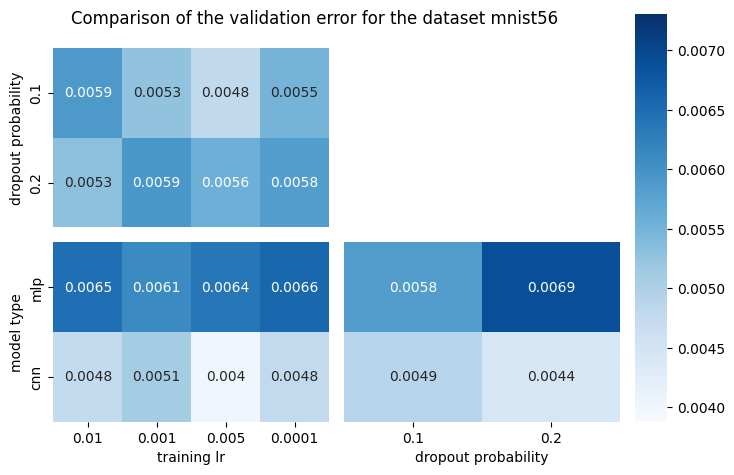

In [51]:
mean_arr = results_matrix.mean(1)
index = 4

fig, axs = plt.subplots(2, 2)
fig.delaxes(axs[0, 1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])

cmap = 'Blues'
vmax = mean_arr[index].max()
vmin = mean_arr[index].min()

lr_mt_arr = pd.DataFrame(mean_arr.mean(2)[index,:,:], index=hps['model_type'], columns=hps['training_lr'])
lr_dp_arr = pd.DataFrame(mean_arr.mean(1)[index,:,:], index=hps['dropout_probability'], columns=hps['training_lr'])
dp_mt_arr = pd.DataFrame(mean_arr.mean(3)[index,:,:], index=hps['model_type'], columns=hps['dropout_probability'])

sn.heatmap(lr_dp_arr, annot=True,ax=axs[0,0],xticklabels=False, cbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,0].set(ylabel="dropout probability")

sn.heatmap(lr_mt_arr, annot=True, ax=axs[1,0], cbar=False, cmap=cmap, vmin=vmin, vmax=vmax,)
axs[1,0].set(xlabel="training lr", ylabel="model type")

sn.heatmap(dp_mt_arr,annot=True, ax=axs[1,1], yticklabels=False, cbar=True, cmap=cmap, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,)
axs[1,1].set(xlabel="dropout probability")


fig.suptitle(f"Comparison of the {values_to_fetch[index].replace('_', ' ')} for the dataset {dataset + str(first_class) + str(second_class)}")
# Layout so plots do not overlap
fig.tight_layout()

plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_{values_to_fetch[index]}_heatmaps.jpg",bbox_inches='tight')

In [52]:
val_of_interest = "p2l_bound"
wanted_model_type = "cnn"
model_df = mean_df[[wanted_model_type in idx for idx in mean_df.index]]
std_model_df = std_df[[wanted_model_type in idx for idx in std_df.index]]

model_type, dropout_probability, training_lr = correct_type_of_entry(model_df.index[model_df[val_of_interest].argmin()].split())

print("model type :", model_type, "dropout probability :", dropout_probability, "learning rate :", training_lr)

best_val_arr = model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
std_val_arr = std_model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
print(f"Validation error: {best_val_arr['validation_error']:.4f}±{std_val_arr['validation_error']:.4f} "
      f'Test error : {best_val_arr['test_error']:.4f}±{std_val_arr['test_error']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
    f'binomial : {best_val_arr['binomial_approximation_shah']:.4f}±{std_val_arr['binomial_approximation_shah']:.4f} ',
     f'P2L bound : {best_val_arr['p2l_bound']:.4f}±{std_val_arr['p2l_bound']:.4f} ', 
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ')

model type : cnn dropout probability : 0.2 learning rate : 0.001
Validation error: 0.0046±0.0012 Test error : 0.0047±0.0015  KL bound : 0.0629±0.0022  binomial : 0.0624±0.0022  P2L bound : 0.0135±0.0006  compression set size : 117.0000±5.1769 


The best bound for run 42 happens at 70 datapoints with a bound value of 0.05750508478259138
The best bound for run 4 happens at 80 datapoints with a bound value of 0.05205701211043064
The best bound for run 3 happens at 60 datapoints with a bound value of 0.057878674757399995
The best bound for run 2 happens at 50 datapoints with a bound value of 0.05180580506386612
The best bound for run 1 happens at 70 datapoints with a bound value of 0.05067675860814945
Mean value of the best bounds taken separately : 0.05398466706448751
Mean value of the compression size of best bounds : 66.0


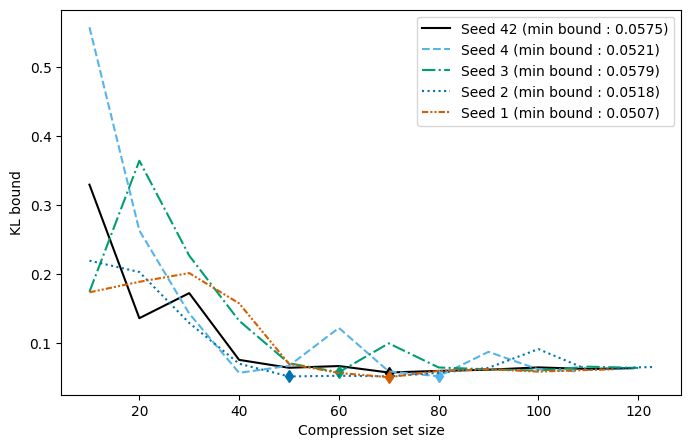

In [53]:
from bounds.real_valued_bounds import compute_epsilon, kl_bound

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
colors = ["#000000", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]

plt.figure(figsize=(8,5))
run_list = []

for run in runs:
    if run.config['model_type'] == model_type:
        if run.config['training_lr'] == training_lr:
            if run.config['dropout_probability'] == dropout_probability:
                run_list.append(run)

all_seeds_bounds = []
max_length_run = 0
max_comp_sizes = []
counter = 0
best_comp_set_size = []
for run in run_list:
    history = run.scan_history(keys=["complement_error"])
    losses = [row["complement_error"] for row in history]
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(losses)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])

    if compression_sizes.shape[0] > max_length_run:
        max_length_run = compression_sizes.shape[0]
        max_comp_sizes = compression_sizes
        
    bound_list = []
    for idx in range(len(losses)):
        epsilon = compute_epsilon(compression_sizes[idx], 1, run.summary['train_set_size'], run.config['delta'])
        bound = kl_bound(compression_sizes[idx], run.summary['train_set_size'], float(losses[idx]), epsilon)
        bound_list.append(bound)
    plt.plot(compression_sizes, bound_list,'d',
             markevery=[np.array(bound_list).argmin()],
             linestyle=linestyles[counter], #ms=8, #mew=1.2,
             color=colors[counter],
             label=f"Seed {run.config['seed']} (min bound : {min(bound_list):.4f})")
    best_idx = np.array(bound_list).argmin()
    best_comp_set_size.append(compression_sizes[best_idx])
    print(f"The best bound for run {run.config['seed']} happens at {compression_sizes[best_idx]} datapoints with a bound value of {bound_list[best_idx]}")
    all_seeds_bounds.append(bound_list)
    counter += 1

plt.xlabel("Compression set size")
plt.ylabel("KL bound")
print(f"Mean value of the best bounds taken separately : {sum([min(l) for l in all_seeds_bounds])/5}")
print(f"Mean value of the compression size of best bounds : {sum(best_comp_set_size)/5}")
plt.legend(markerscale=0)
# plt.title(f"Comparison of the behavior of the bound on {dataset + str(first_class) + str(second_class)}")
plt.savefig(f"./results/binary_mnist/{dataset}_{first_class}_{second_class}_min_bound_comparison.jpg")


In [23]:
from bounds.classical_bounds import binomial_approximation
from bounds.bound_utils import zeta, log_binomial_coefficient
from time import sleep

new_vals_to_fetch = deepcopy(values_to_fetch)
new_vals_to_fetch.append("complement_error")
new_vals_to_fetch.remove("p2l_bound")
new_vals_to_fetch.remove("binomial_approximation_shah")
early_stop_result_matrix = np.ones(((len(new_vals_to_fetch)+1,) + size_hyperparams))

for run_idx in range(len(runs)):
    sleep(10)
    run = runs[run_idx]
    kl_history = run.scan_history(keys=["kl_bound"])
    kl_list = [row["kl_bound"] for row in kl_history]
    kl_idx = np.argmin(kl_list)
    
    val_sizes = run.config['data_groupsize'] * run.config['log_iterations']
    compression_sizes = np.array(list(range(1,len(kl_list)))) * val_sizes
    compression_sizes = np.append(compression_sizes, run.summary['compression_set_size'])
    
    for val_to_fetch_idx in range(len(new_vals_to_fetch)):
        matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
        val_to_fetch = new_vals_to_fetch[val_to_fetch_idx]
        history = run.scan_history(keys=[val_to_fetch])
        losses = [row[val_to_fetch] for row in history]
        if val_to_fetch == "validation_error" and len(losses) == 1:
            history = run.scan_history(keys=["val_error"])
            losses = [row["val_error"] for row in history]
            losses.append(run.summary["validation_error"])
        if val_to_fetch == "compression_set_size":
            losses = compression_sizes
            # TO BE REMOVED
        if val_to_fetch == "test_error":
            if dataset + str(first_class) + str(second_class) == "mnist49":
                if len(losses) == 1:
                    history = run.scan_history(keys=["test_results"])
                    test_error = [row["test_results"] for row in history]
                    test_error.append(run.summary['test_error'])
                    losses = test_error
        early_stop_result_matrix[matrix_idx] = losses[kl_idx]

    matrix_idx = tuple([hps[key].index(run.config[key]) for key in hps.keys()])
    complement_error = early_stop_result_matrix[(new_vals_to_fetch.index('complement_error'),) + matrix_idx]
    m = early_stop_result_matrix[(new_vals_to_fetch.index('compression_set_size'),) + matrix_idx]
    n = run.summary['train_set_size']
    k = complement_error * (n-m)
    
    log_delta = np.log(zeta(m)*run.config['delta']) - log_binomial_coefficient(n,m)
    delta_prime = np.exp(log_delta)
    early_stop_result_matrix[(-1,) + matrix_idx] = binomial_approximation(k, n-m, log_delta)

KeyboardInterrupt: 

In [ ]:
early_stop_matrix = early_stop_result_matrix.mean(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
l = deepcopy(new_vals_to_fetch)
l.append("binomial_approximation_shah")
mean_early_stop_df = pd.DataFrame(early_stop_matrix, index=name_list, columns=l)
mean_early_stop_df

In [ ]:
mean_early_stop_df.to_csv(f"./results/binary_mnist/mean_{project}.csv")

In [ ]:
early_stop_std = early_stop_result_matrix.std(1).reshape(early_stop_result_matrix.shape[0],np.prod(early_stop_result_matrix.shape[2:])).T
std_early_stop_df = pd.DataFrame(early_stop_std, index=name_list, columns=l)
mean_early_stop_df.to_csv(f"./results/binary_mnist/std_{project}.csv")

In [ ]:
mean_arr = early_stop_result_matrix.mean(1)
index = 2

fig, axs = plt.subplots(2, 2)
fig.delaxes(axs[0, 1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])

cmap = 'Blues'
vmax = mean_arr[index].max()
vmin = mean_arr[index].min()

lr_mt_arr = pd.DataFrame(mean_arr.mean(2)[index,:,:], index=hps['model_type'], columns=hps['training_lr'])
lr_dp_arr = pd.DataFrame(mean_arr.mean(1)[index,:,:], index=hps['dropout_probability'], columns=hps['training_lr'])
dp_mt_arr = pd.DataFrame(mean_arr.mean(3)[index,:,:], index=hps['model_type'], columns=hps['dropout_probability'])

sn.heatmap(lr_dp_arr, annot=True,ax=axs[0,0],xticklabels=False, cbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
axs[0,0].set(ylabel="dropout probability")

sn.heatmap(lr_mt_arr, annot=True, ax=axs[1,0], cbar=False, cmap=cmap, vmin=vmin, vmax=vmax,)
axs[1,0].set(xlabel="training lr", ylabel="model type")

sn.heatmap(dp_mt_arr,annot=True, ax=axs[1,1], yticklabels=False, cbar=True, cmap=cmap, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax,)
axs[1,1].set(xlabel="dropout probability")


fig.suptitle(f"Comparison of the {new_vals_to_fetch[index].replace('_', ' ')} for the dataset {dataset + str(first_class) + str(second_class)}")
# Layout so plots do not overlap
fig.tight_layout()

plt.savefig(f"./results/binary_mnist/early_stop_{dataset}_{first_class}_{second_class}_{new_vals_to_fetch[index]}_heatmaps.jpg",bbox_inches='tight')

In [ ]:
from bounds.classical_bounds import compute_classical_compression_bounds
val_of_interest = "kl_bound"
wanted_model_type = "cnn"
model_df = mean_early_stop_df[[wanted_model_type in idx for idx in mean_early_stop_df.index]]
std_model_df = std_early_stop_df[[wanted_model_type in idx for idx in std_early_stop_df.index]]

model_type, dropout_probability, training_lr = correct_type_of_entry(model_df.index[model_df[val_of_interest].argmin()].split())

print("model type :", model_type, "dropout probability :", dropout_probability, "learning rate :", training_lr)

best_val_arr = model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
std_val_arr = std_model_df.loc[model_df.index[model_df[val_of_interest].argmin()]]
print(f"Complement error: {100*best_val_arr['complement_error']:.2f}±{100*std_val_arr['complement_error']:.2f} "
    f"Validation error: {100*best_val_arr['validation_error']:.2f}±{100*std_val_arr['validation_error']:.2f} "
      f'Test error : {100*best_val_arr['test_error']:.2f}±{100*std_val_arr['test_error']:.2f} ', 
      f"KL bound : {100*best_val_arr['kl_bound']:.2f}±{100*std_val_arr['kl_bound']:.2f} ",
    f"Binomial bound : {100*best_val_arr['binomial_approximation_shah']:.2f}±{100*std_val_arr['binomial_approximation_shah']:.2f} ",
      f'compression set size : {best_val_arr['compression_set_size']:.1f}±{std_val_arr['compression_set_size']:.1f} ')



In [ ]:
print(f"{100*best_val_arr['complement_error']:.2f}$\\pm${100*std_val_arr['complement_error']:.2f} & {100*best_val_arr['validation_error']:.2f}$\\pm${100*std_val_arr['validation_error']:.2f} & {100*best_val_arr['test_error']:.2f}$\\pm${100*std_val_arr['test_error']:.2f} & {100*best_val_arr['kl_bound']:.2f}$\\pm${100*std_val_arr['kl_bound']:.2f} & {100*best_val_arr['binomial_approximation_shah']:.2f}$\\pm${100*std_val_arr['binomial_approximation_shah']:.2f} & {best_val_arr['compression_set_size']:.1f}$\\pm${std_val_arr['compression_set_size']:.1f}")


In [ ]:
print(f"{4.6984:.2f}")